In [1]:
import sys
sys.path.append('../shap')
import shap

import os
sys.path.append('../..')
import numpy as np
import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel
from deepbayesHF.analyzers import FGSM
from deepbayesHF.analyzers import eps_LRP
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import random
import matplotlib.pyplot as plt
from collections import namedtuple

from joblib import Parallel, delayed
import subprocess
from statistics import mode
import json
import tensorflow as tf
import imageio

In [2]:
X_train, y_train = [], []

widths = []
heights = []
train_dir = '/home/rhiba/bayesian-ores/training_data/gtsrb/Final_Training/Images/'
for class_dir in os.listdir(train_dir):
    classid = int(class_dir)
    full_path = os.path.join(train_dir,class_dir)
    images = [x for x in os.listdir(full_path) if x.endswith('.ppm')]
    for i in images:
        actual_image = imageio.imread(os.path.join(full_path,i))
        widths.append(len(actual_image[0]))
        heights.append(len(actual_image))
        X_train.append(actual_image)
        y_train.append(classid)

In [3]:
print('Min and max widths:',min(widths),max(widths))
print('Min and max heights:',min(heights),max(heights))
rescale_size = (30,30)
print('Rescaling to:',rescale_size)

if not rescale_size == X_train[0].shape:
    X_train = np.array(list(map(lambda x:cv2.resize(x,rescale_size,interpolation=cv2.INTER_CUBIC),X_train)))
X_train = X_train/255.

Min and max widths: 25 243
Min and max heights: 25 225
Rescaling to: (30, 30)


In [4]:
zipped = list(zip(X_train,y_train))
#random.shuffle(zipped)
X_train = list(list(zip(*zipped))[0])
y_train = list(list(zip(*zipped))[1])
split_point = int(0.8*len(X_train))
X_test = X_train[split_point:]
X_train = X_train[:split_point]
y_test = y_train[split_point:]
y_train = y_train[:split_point]
X_train = np.array(X_train)
X_test = np.array(X_test)

In [8]:
model_name = f'GTSRB_SHAP_30x30'

opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()

inputs = Input(shape=X_train[0].shape)
tmp = Conv2D(4,3,padding='same',activation='relu')(inputs)
tmp = MaxPooling2D()(tmp)
tmp = Conv2D(8,3,padding='same',activation='relu')(tmp)
tmp = MaxPooling2D()(tmp)
tmp = Flatten()(tmp)
tmp = Dense(128,activation='relu')(tmp)
predictions = Dense(43,activation='softmax')(tmp)
model = Model(inputs=inputs,outputs=predictions)

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')
bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(3, 3, 3, 4) 0.2721655269759087
(3, 3, 4, 8) 0.23570226039551584
(392, 128) 0.07142857142857142
(128, 43) 0.125
deepbayes: Using implicit prior
(3, 3, 3, 4) 0.2721655269759087
(3, 3, 4, 8) 0.23570226039551584
(392, 128) 0.07142857142857142
(128, 43) 0.125


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 1, loss: 3.622, acc: 0.058, val_loss: 3.454, val_acc: 0.091


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 2, loss: 3.351, acc: 0.103, val_loss: 2.994, val_acc: 0.218


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 3, loss: 2.418, acc: 0.348, val_loss: 1.868, val_acc: 0.451


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 4, loss: 1.534, acc: 0.529, val_loss: 1.217, val_acc: 0.630


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 5, loss: 1.075, acc: 0.660, val_loss: 0.894, val_acc: 0.718


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 6, loss: 0.763, acc: 0.756, val_loss: 0.687, val_acc: 0.787


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 7, loss: 0.581, acc: 0.816, val_loss: 0.569, val_acc: 0.829


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 8, loss: 0.445, acc: 0.858, val_loss: 0.465, val_acc: 0.866


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 9, loss: 0.340, acc: 0.890, val_loss: 0.447, val_acc: 0.882


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 10, loss: 0.306, acc: 0.904, val_loss: 0.413, val_acc: 0.885


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 11, loss: 0.260, acc: 0.917, val_loss: 0.388, val_acc: 0.896


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 12, loss: 0.243, acc: 0.923, val_loss: 0.362, val_acc: 0.901


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 13, loss: 0.194, acc: 0.937, val_loss: 0.346, val_acc: 0.909


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 14, loss: 0.175, acc: 0.946, val_loss: 0.285, val_acc: 0.926


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 15, loss: 0.161, acc: 0.950, val_loss: 0.292, val_acc: 0.924


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 16, loss: 0.144, acc: 0.956, val_loss: 0.291, val_acc: 0.929


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 17, loss: 0.126, acc: 0.958, val_loss: 0.289, val_acc: 0.927


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 18, loss: 0.124, acc: 0.960, val_loss: 0.276, val_acc: 0.930


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 19, loss: 0.116, acc: 0.962, val_loss: 0.248, val_acc: 0.939


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 20, loss: 0.092, acc: 0.970, val_loss: 0.230, val_acc: 0.947


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 21, loss: 0.086, acc: 0.973, val_loss: 0.278, val_acc: 0.937


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 22, loss: 0.073, acc: 0.975, val_loss: 0.256, val_acc: 0.943


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 23, loss: 0.072, acc: 0.977, val_loss: 0.248, val_acc: 0.947


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 24, loss: 0.080, acc: 0.975, val_loss: 0.270, val_acc: 0.944


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch 25, loss: 0.090, acc: 0.973, val_loss: 0.271, val_acc: 0.941


100%|██████████| 393/393 [00:13<00:00, 28.52it/s]


Epoch 26, loss: 0.089, acc: 0.972, val_loss: 0.301, val_acc: 0.938
('batch_size', 64)
('learning_rate', 0.25)
('decay', 0.0)
('epochs', 26)
('inflate_prior', 2.0)
('input_noise', 0.0)
('robust_train', 0)
('epsilon', 0.1)
('robust_lambda', 0.5)
('loss_monte_carlo', 2)
('input_upper', inf)
('input_lower', -inf)
('beta_1', 0.999)
('beta_2', 0.9999)
('lam', 1.0)
('N', 25093)
('max_eps', 0.1)
('max_robust_lambda', 0.5)


In [5]:
model_name = f'GTSRB_SHAP_30x30'
bayes_model = PosteriorModel(model_name)
y_pred = bayes_model.predict(X_test[:50],n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test[:50],np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 128)              

Prediction: 38
n: 4137


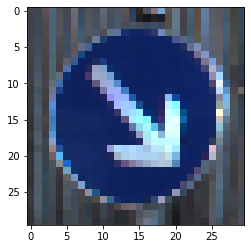

In [6]:
N = 50
n = 0
while True:
    n = np.random.randint(0,len(y_train))
    n = 4137
    X = X_train[n].reshape(1,*X_train[n].shape).astype(float)

    
    #### GET CORRECTLY CLASSIFIED INPUT 
    y_hat = np.argmax(bayes_model.predict(X,n=N))
    if y_train[n] == y_hat:
        break
    

plt.imshow(X_train[n],vmin=0,vmax=1)
print('Prediction:',y_hat)
print('n:',n)

In [62]:
#background = X_train[np.random.choice(X_train.shape[0],100,replace=False)]
#bayes_model.set_weights(bayes_model.sample())
#model = bayes_model.model
#e = shap.DeepExplainer(model,background)
#shap_values = e.shap_values(X)

In [63]:
#print(X.shape)
#print(shap_values[0].shape)
#shap.image_plot(shap_values,-X)

In [7]:
background = X_train[np.random.choice(X_train.shape[0],200,replace=False)]

if not os.path.exists(f'exps/exp{n}'):
    os.mkdir(f'exps/exp{n}')
    
input_path = f'exps/exp{n}/X.npy'
background_path = f'exps/exp{n}/bg.npy'
y_path = f'exps/exp{n}/y.npy'
np.save(y_path,y_hat,False)
np.save(input_path,X,False)
np.save(background_path,background,False)

iterations = 50
for i in range(iterations):
    subprocess.Popen(['python3','get_SHAP_exp.py',str(i),model_name,input_path,f'exps/exp{n}',background_path])
        
full = False 
while not full:
    if len([name for name in os.listdir(f'exps/exp{n}') if os.path.isfile(os.path.join(f'exps/exp{n}', name))]) == iterations+2:
        full = True

KeyboardInterrupt: 

In [18]:
# read in and display the results from the above
ns = [4137]
ns_exps = []
exps_per_ns = dict()
for n in ns:
    all_exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('bg') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            # the shap.image_plot function only works with an outer list, not np array (no idea why, its the same shape)
            if tmp.shape == (43,1,30,30,3):
                tmp = tmp[y_train[n]].reshape(30,30,3)[:,:,0]
                all_exps.append(tmp)

    coverage_map = dict()
    max_rel = np.max(all_exps)
    limit = 0.004*max_rel
    for exp in all_exps:
        exp[exp < limit] = 0
        exp[exp > 0] = 1
        #plt.imshow(exp)
        #plt.show()
    ns_exps.append(all_exps)

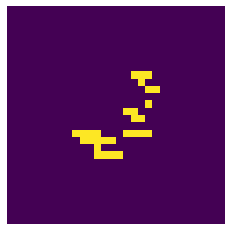

1 2.0


In [19]:
for exps in ns_exps:
    cmap = dict()
    names = []
    es = []
    for e in exps:
        if not str(e) in names:
            names.append(str(e))
            es.append(e)
            cmap[names.index(str(e))] = 0
        cmap[names.index(str(e))] += 1

    res = max(cmap,key=cmap.get)
    res_image = es[res]
    plt.imshow(res_image)
    plt.axis('off')
    plt.show()
    cov = (cmap[res]/50)*100

    print(cmap[res],cov)

In [20]:
from memo import memo

@memo
def generate_min_exps(expl,threshold):
    exps = []
    for i in range(len(expl)):
        orig_expl = expl
        if orig_expl[i] == 0:
            continue
        else:
            if i == len(expl) - 1:
                s = sum(orig_expl[:i])
            else:
                s = sum(orig_expl[:i])+sum(orig_expl[i+1:])
            if s < threshold:
                exps.append(expl)
                break
            else:
                new_expl = tuple(orig_expl[:i]) + (0,)
                if i < len(expl)-1:
                    new_expl = new_expl + tuple(orig_expl[i+1:])
                new_exps = generate_min_exps(new_expl,threshold)
                exps += new_exps
    return exps

In [29]:
import ast
ns = [4137]
exps = dict()
ns_exps = []
for n in ns:
    all_exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('bg') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            # the shap.image_plot function only works with an outer list, not np array (no idea why, its the same shape)
            if tmp.shape == (43,1,30,30,3):
                tmp = tmp[y_train[n]].reshape(30,30,3)[:,:,0]
                all_exps.append(tmp)
            
    net_count = len(all_exps)
    #print(net_count)
    coverage_map = dict()
    max_rel = np.max(all_exps)
    limit = 0.004*max_rel
    all_new_exps = []
    for exp in all_exps[:3]+all_exps[4:5]:
        print(exp.shape)
        exp[exp < limit] = 0
        exp[exp > 0] = 1
        exp_list = list(set(generate_min_exps(tuple(exp.flatten()),0.98*np.sum(exp))))
        all_new_exps += exp_list
    ns_exps.append(all_new_exps)

(30, 30)
(30, 30)
(30, 30)
(30, 30)


68


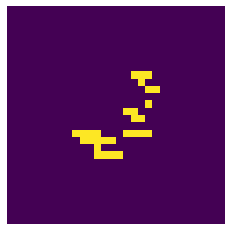

1 2.0


In [30]:
for exps in ns_exps:
    cmap = dict()
    pic_map = dict()
    print(len(exps))
    for e in exps:
        e = np.array(e)
        if not str(e) in cmap.keys():
            cmap[str(e)] = 0
            pic_map[str(e)] = np.array(e).reshape(30,30)
        #else:
        #    print('dupe')
        cmap[str(e)] += 1

    res = max(cmap,key=cmap.get)
    res_image = pic_map[res]
    plt.imshow(res_image)
    plt.axis('off')
    plt.show()
    cov = (cmap[res]/50)*100

    print(cmap[res],cov)

## Display All Explanations From Sampled BNNs

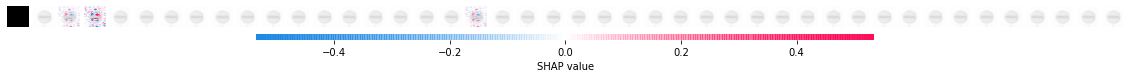

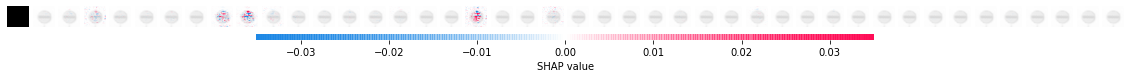

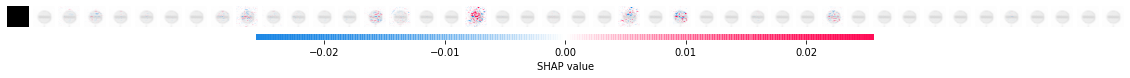

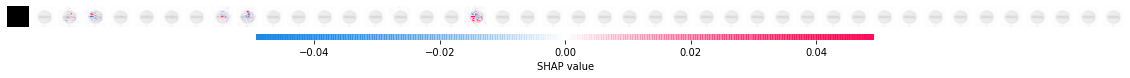

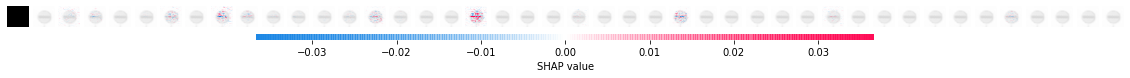

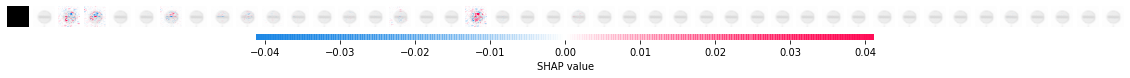

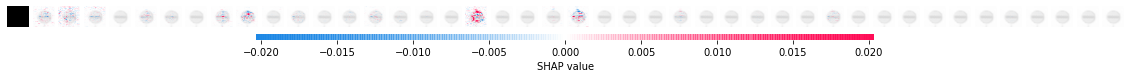

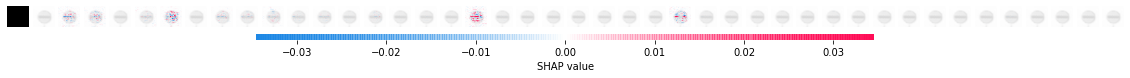

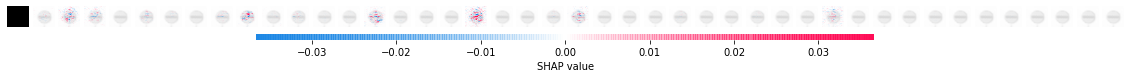

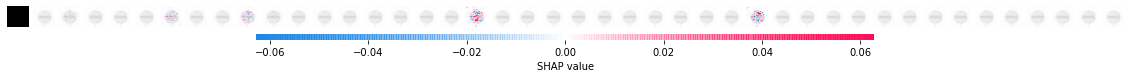

In [14]:
# read in and display the results from the above
ns = [4137]

exps_per_ns = dict()
for n in ns:
    exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('bg') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            # the shap.image_plot function only works with an outer list, not np array (no idea why, its the same shape)
            tmp = [tmp[i] for i in range(tmp.shape[0])]
            exps.append(tmp)

    X = np.load(f'exps/exp{n}/X.npy')
    for exs in exps:
        shap.image_plot(exs, -X)
    exps_per_ns[n] = exps.copy()
    print('==============================================')

22
[22, 18, 25, 18, 22, 22, 22, 18, 25, 22, 13, 28, 13, 22, 22, 22, 18, 18, 25, 29, 18, 33, 22, 25, 22, 13, 22, 22, 25, 36, 38, 22, 25, 25, 22, 18, 39, 25, 13, 22, 18, 25, 22, 18, 25, 25, 25, 25, 25, 22]
Prediction: 22
n: 24320


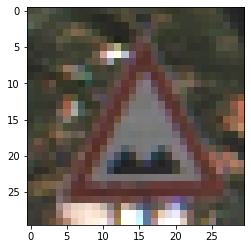

In [22]:
N = 50
n = 0
while True:
    n = np.random.randint(0,len(y_train))
    X = X_train[n].reshape(1,*X_train[n].shape).astype(float)
    

    bayes_model.set_weights(bayes_model.sample())
    prediction = [np.array(bayes_model._predict(X))[0]]
    for i in range(N-1):
        bayes_model.set_weights(bayes_model.sample())
        prediction.append(np.array(bayes_model._predict(X))[0])
    y_hat_ls = list(np.argmax(prediction,axis=1))
    y_hat = mode(y_hat_ls)
    if y_hat_ls.count(y_hat) < 0.6*50 and y_train[n] == y_hat:
        print(y_hat)
        print(y_hat_ls)
        break
    

plt.imshow(X_train[n],vmin=0,vmax=1)
print('Prediction:',y_hat)
print('n:',n)

In [23]:
background = X_train[np.random.choice(X_train.shape[0],200,replace=False)]

if not os.path.exists(f'exps/exp{n}'):
    os.mkdir(f'exps/exp{n}')
    
input_path = f'exps/exp{n}/X.npy'
background_path = f'exps/exp{n}/bg.npy'
y_path = f'exps/exp{n}/y.npy'
np.save(y_path,y_hat,False)
np.save(input_path,X,False)
np.save(background_path,background,False)

iterations = 10
for i in range(iterations):
    subprocess.Popen(['python3','get_SHAP_exp.py',str(i),model_name,input_path,f'exps/exp{n}',background_path])
        
full = False 
while not full:
    if len([name for name in os.listdir(f'exps/exp{n}') if os.path.isfile(os.path.join(f'exps/exp{n}', name))]) == iterations+2:
        full = True

Class: 5


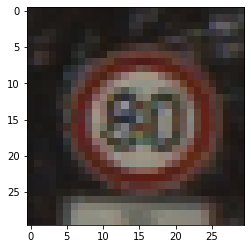

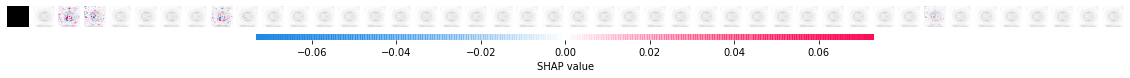

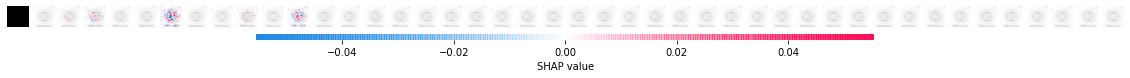

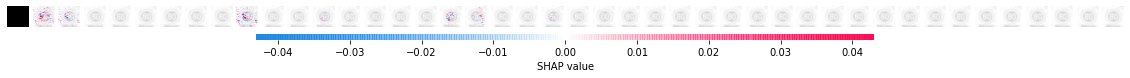

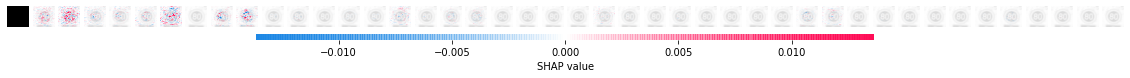

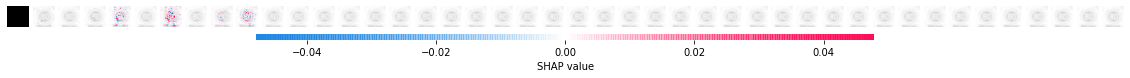

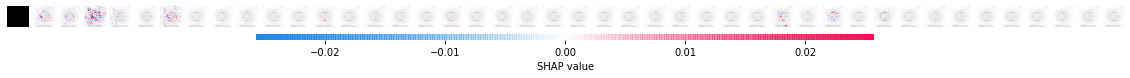

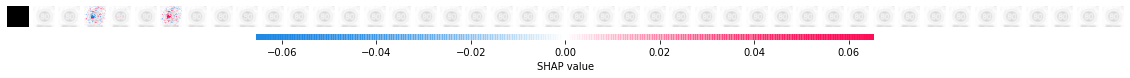

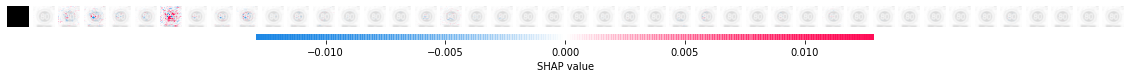

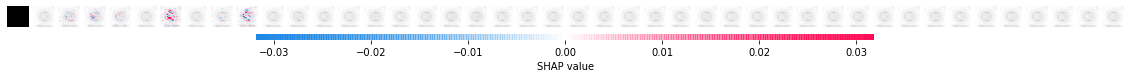

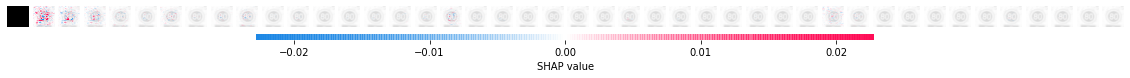

Class: 22


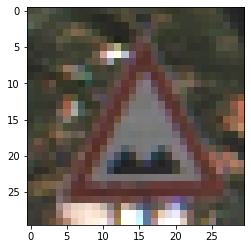

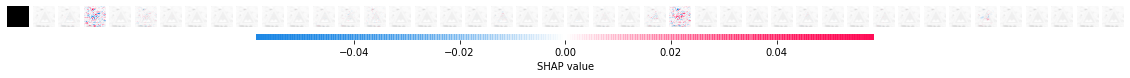

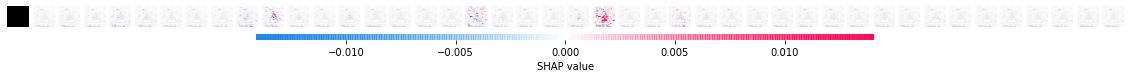

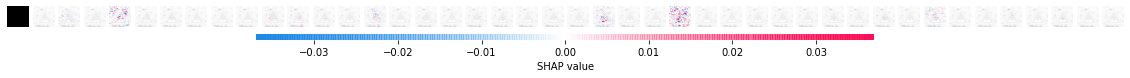

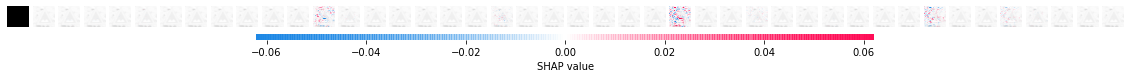

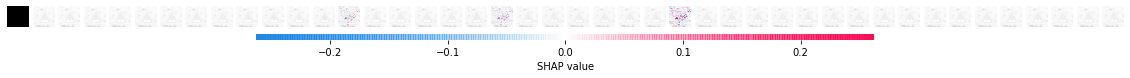

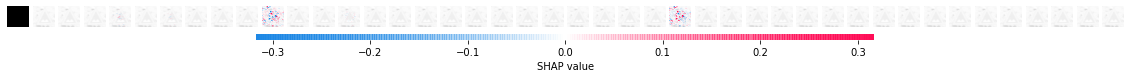

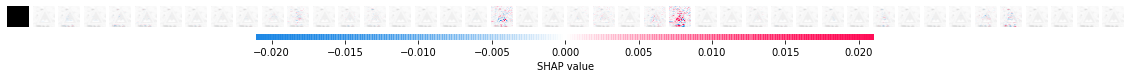

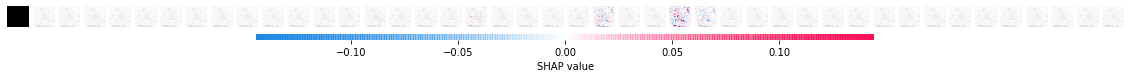

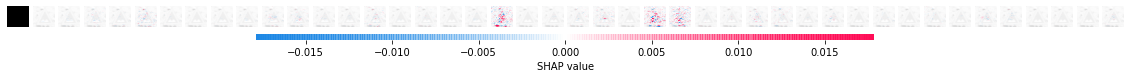

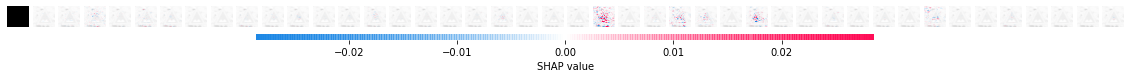

In [24]:
# read in and display the results from the above
ns = [18307,24320]

exps_per_ns = dict()
for n in ns:
    exps = []
    for f in os.listdir(f'exps/exp{n}'):
        if os.path.isfile(os.path.join(f'exps/exp{n}',f)) and not f.startswith('X') and not f.startswith('bg') and not f.startswith('y'):
            tmp = np.load(os.path.join(f'exps/exp{n}',f))
            # the shap.image_plot function only works with an outer list, not np array (no idea why, its the same shape)
            tmp = [tmp[i] for i in range(tmp.shape[0])]
            exps.append(tmp)

    X = np.load(f'exps/exp{n}/X.npy')
    y = np.load(f'exps/exp{n}/y.npy')
    print("Class:",y)
    plt.imshow(X.reshape(X.shape[1:]))
    for exs in exps:
        shap.image_plot(exs, -X)
    exps_per_ns[n] = exps.copy()
    print('==============================================')